The Wikipedia API code example can be found in the wp_article_views_example notebook and falls under the CC-BY license (https://creativecommons.org/licenses/by/4.0/).

To replicate the analysis, run the blocks of code in the provided order. The code for Step 1 (Data Acquisition) can take a while to run but the output files from those code blocks are already generated and ready for use by Step 2. Therefore, it is possible to run the code block up to Step 1, skip Step 1, and continue on starting from Step 2 to generate the analysis charts.

# Install all external modules

These modules are required in order to run the code in the notebook.

In [1]:
# install requests module
!pip install requests
!pip install pandas
!pip install matplotlib


[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Import the following libraries for later use!

In [2]:
# Import standard python modules
import json, time, urllib.parse

# Import extra module
import requests
import pandas as pd
import matplotlib.pyplot as plt

The following block of code is borrowed from the wp_article_views_example notebook. These constants are used to help clean up the API requests.

In [3]:
#########
#
#    CONSTANTS
#

# The REST API 'pageviews' URL - this is the common URL/endpoint for all 'pageviews' API requests
API_REQUEST_PAGEVIEWS_ENDPOINT = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/'

# This is a parameterized string that specifies what kind of pageviews request we are going to make
# In this case it will be a 'per-article' based request. The string is a format string so that we can
# replace each parameter with an appropriate value before making the request
API_REQUEST_PER_ARTICLE_PARAMS = 'per-article/{project}/{access}/{agent}/{article}/{granularity}/{start}/{end}'

# The Pageviews API asks that we not exceed 100 requests per second, we add a small delay to each request
API_LATENCY_ASSUMED = 0.002       # Assuming roughly 2ms latency on the API and network
API_THROTTLE_WAIT = (1.0/100.0)-API_LATENCY_ASSUMED

# When making a request to the Wikimedia API they ask that you include your email address which will allow them
# to contact you if something happens - such as - your code exceeding rate limits - or some other error 
REQUEST_HEADERS = {
    'User-Agent': '<ashwin19@uw.edu>, University of Washington, MSDS DATA 512 - AUTUMN 2024',
}

# This is just a list of English Wikipedia article titles that we can use for example requests
ARTICLE_TITLES = [ 'Bison', 'Northern flicker', 'Red squirrel', 'Chinook salmon', 'Horseshoe bat' ]

# This template is used to map parameter values into the API_REQUST_PER_ARTICLE_PARAMS portion of an API request. The dictionary has a
# field/key for each of the required parameters. In the example, below, we only vary the article name, so the majority of the fields
# can stay constant for each request. Of course, these values *could* be changed if necessary.
ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE = {
    "project":     "en.wikipedia.org",
    "access":      "desktop",  # "mobile-app" or "mobile-web" or "all-access"
    "agent":       "user",
    "article":     "",             
    "granularity": "monthly",
    "start":       "2015070100",
    "end":         "2024093000"  
}

The following block of code is also borowed from the wp_article_views_example notebook. This code defines a helper function that will be called to make the API requests using the constants defined in the prior block.

In [4]:
#########
#
#    PROCEDURES/FUNCTIONS
#

def request_pageviews_per_article(access_type, article_title = None, 
                                  endpoint_url = API_REQUEST_PAGEVIEWS_ENDPOINT, 
                                  endpoint_params = API_REQUEST_PER_ARTICLE_PARAMS, 
                                  request_template = ARTICLE_PAGEVIEWS_PARAMS_TEMPLATE,
                                  headers = REQUEST_HEADERS):

    # article title can be as a parameter to the call or in the request_template
    if article_title:
        request_template['article'] = article_title

    if not request_template['article']:
        raise Exception("Must supply an article title to make a pageviews request.")
        
    request_template['access'] = access_type

    # Titles are supposed to have spaces replaced with "_" and be URL encoded
    article_title_encoded = urllib.parse.quote(request_template['article'].replace(' ','_'))
    request_template['article'] = article_title_encoded
    
    # now, create a request URL by combining the endpoint_url with the parameters for the request
    request_url = endpoint_url+endpoint_params.format(**request_template)
    
    # make the request
    try:
        # we'll wait first, to make sure we don't exceed the limit in the situation where an exception
        # occurs during the request processing - throttling is always a good practice with a free
        # data source like Wikipedia - or other community sources
        if API_THROTTLE_WAIT > 0.0:
            time.sleep(API_THROTTLE_WAIT)
        response = requests.get(request_url, headers=headers)
        json_response = response.json()
    except Exception as e:
        print(e)
        json_response = None
    return json_response

Read in the list of article names from the rare-disease_cleaned.AUG.2024.csv file!

In [ ]:
df = pd.read_csv('rare-disease_cleaned.AUG.2024.csv')
df = df.reset_index()

# Step 1: Data Acquisition

For each article title, make an API call to get the page view counts for all the available months in our target date range (July 1st, 2015 to September 30th, 2024). Parse the response and save the view counts as a json object file.

The code in Step 1 can be skipped. To do this, move directly to Step 2 assuming all prior code blocks have been already run.

The following block of code handles Desktop access types

Name of the file: rare-disease_monthly_desktop_201507-202409.json

Note: This block of code takes a while to run!

In [ ]:
# Parse desktop data
desktop_data = {}

# Iterate over each article
for index, row in df.iterrows():
    disease = row['disease']
    print("Getting pageview data for: ", disease)
    # Request page view data
    views = request_pageviews_per_article("desktop", disease)
    if "status" in views:
        if views["status"] == 404: # Skip this article if bad response
            continue
    disease_counts = []
    
    # Convert page view data into json format
    for month in views['items']:
        disease_counts.append({
            'project': month['project'],
            'article': month['article'],
            'granularity': month['granularity'],
            'timestamp': month['timestamp'],
            'agent': month['agent'],
            'views': month['views']    
        })
    
    desktop_data[disease] = disease_counts
    
# Write the json data to a file
desktop_json = json.dumps(desktop_data)
with open("rare-disease_monthly_desktop_201507-202409.json", "w") as file: 
    file.write(desktop_json)
    

The following block of code handles All Access (Desktop AND Mobile) types

Name of the file: rare-disease_monthly_cumulative_201507-202409.json

Note: This block of code takes a while to run!

In [ ]:
# Parse all-access data
all_data = {}

# Iterate over each article
for index, row in df.iterrows():
    disease = row['disease']
    print("Getting pageview data for: ", disease)
    # Request page view data
    views = request_pageviews_per_article("all-access", disease)
    if "status" in views:
        if views["status"] == 404: # Skip this article if bad response
            continue
    disease_counts = []
    
    # Convert page view data into json format
    for month in views['items']:
        disease_counts.append({
            'project': month['project'],
            'article': month['article'],
            'granularity': month['granularity'],
            'timestamp': month['timestamp'],
            'agent': month['agent'],
            'views': month['views']    
        })
    
    all_data[disease] = disease_counts
    
# Write the json data to a file
all_json = json.dumps(all_data)
with open("rare-disease_monthly_cumulative_201507-202409.json", "w") as file: 
    file.write(all_json)
    

The following block of code handles Mobile access types

Name of the file: rare-disease_monthly_mobile_201507-202409.json

Note: This block of code takes a while to run!

In [ ]:
# Parse mobile data
mobile_data = {}

# Iterate over each article
for index, row in df.iterrows():
    disease = row['disease']
    print("Getting pageview data for: ", disease)
    # Request page view data for app and web access types
    views_web = request_pageviews_per_article("mobile-web", disease)
    views_app = request_pageviews_per_article("mobile-app", disease)
    if "status" in views_web:
        if views_web["status"] == 404: # Skip this article if bad response
            continue
    disease_counts = []

    # Convert page view data into json format
    for i in range(0, len(views_web['items'])):
        # Need to add the app count and the web count
        total = int(views_web['items'][i]['views']) + int(views_app['items'][i]['views'])
        disease_counts.append({
            'project': views_web['items'][i]['project'],
            'article': views_web['items'][i]['article'],
            'granularity': views_web['items'][i]['granularity'],
            'timestamp': views_web['items'][i]['timestamp'],
            'agent': views_web['items'][i]['agent'],
            'views': total
        })

    mobile_data[disease] = disease_counts

# Write the json data to a file
mobile_json = json.dumps(mobile_data)
with open("rare-disease_monthly_mobile_201507-202409.json", "w") as file: 
    file.write(mobile_json)

# Step 2: Data Analysis
Conduct 3 basic visualizations.

## Visualization 1
Create a time series chart showing the highest and lowest average viewed page for Desktop and Mobile Access:

The following block of code contains helper functions to process the JSON object data that was created in step 1.

In [8]:
dates_full = ['2015-07-01', '2015-08-01', '2015-09-01', '2015-10-01', '2015-11-01', '2015-12-01', '2016-01-01', '2016-02-01', '2016-03-01', '2016-04-01', '2016-05-01', '2016-06-01', '2016-07-01', '2016-08-01', '2016-09-01', '2016-10-01', '2016-11-01', '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01', '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01', '2017-08-01', '2017-09-01', '2017-10-01', '2017-11-01', '2017-12-01', '2018-01-01', '2018-02-01', '2018-03-01', '2018-04-01', '2018-05-01', '2018-06-01', '2018-07-01', '2018-08-01', '2018-09-01', '2018-10-01', '2018-11-01', '2018-12-01', '2019-01-01', '2019-02-01', '2019-03-01', '2019-04-01', '2019-05-01', '2019-06-01', '2019-07-01', '2019-08-01', '2019-09-01', '2019-10-01', '2019-11-01', '2019-12-01', '2020-01-01', '2020-02-01', '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01', '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01', '2020-11-01', '2020-12-01', '2021-01-01', '2021-02-01', '2021-03-01', '2021-04-01', '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01', '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01', '2022-01-01', '2022-02-01', '2022-03-01', '2022-04-01', '2022-05-01', '2022-06-01', '2022-07-01', '2022-08-01', '2022-09-01', '2022-10-01', '2022-11-01', '2022-12-01', '2023-01-01', '2023-02-01', '2023-03-01', '2023-04-01', '2023-05-01', '2023-06-01', '2023-07-01', '2023-08-01', '2023-09-01', '2023-10-01', '2023-11-01', '2023-12-01', '2024-01-01', '2024-02-01', '2024-03-01', '2024-04-01', '2024-05-01', '2024-06-01', '2024-07-01', '2024-08-01', '2024-09-01']

# Open and read the json data for desktop and mobile access to use later
f1 = open('rare-disease_monthly_desktop_201507-202409.json')
f2 = open('rare-disease_monthly_mobile_201507-202409.json')
d_data = json.load(f1)
m_data = json.load(f2)

# This function takes a string of format "YYYYMMDDHH" and turns into "YYYY-MM-DD"
def convertTimeStamp(timestamp):
    return timestamp[0:4] + "-" + timestamp[4:6] + "-" + timestamp[6:8]

# This function takes in an article name and access type and returns an 
# array containing the page view data for each month from that article.
# If an article is missing a month of data, it is represented by a 0.
def getDiseaseArrays(disease, access):
    data = -1
    if access == 'desktop':
        data = d_data
    if access == 'mobile':
        data = m_data
    data_array = data[disease]
    
    views = []
    i = 0
    for date in dates_full:
        if convertTimeStamp(data_array[i]['timestamp']) == date:
            views.append(data_array[i]['views'])
            i = i + 1
        else:
            views.append(0)

    return views

Find the max and min average viewed pages and construct the time series chart. The chart can also be found in the base folder of the repository.

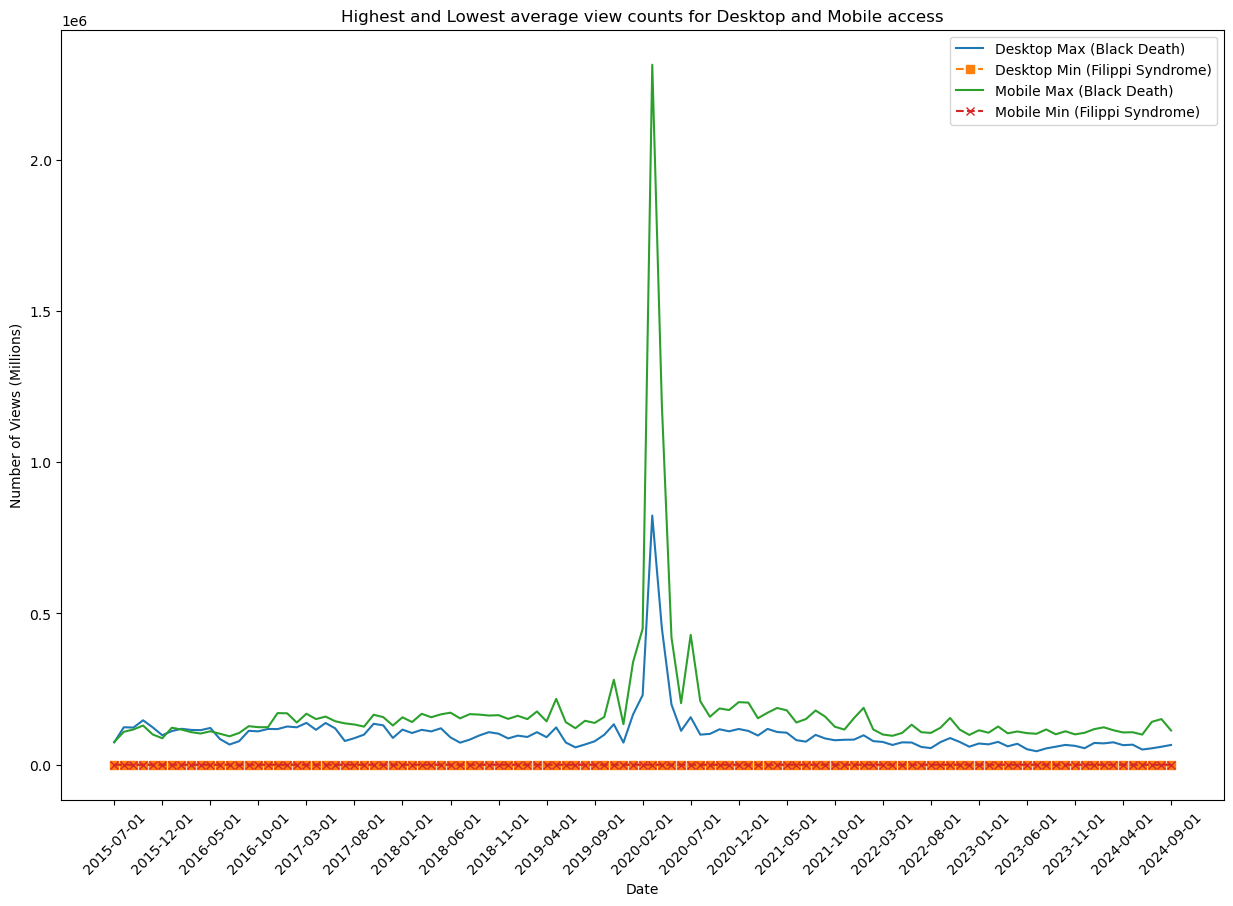

In [31]:
# Get the highest and lowest average for desktop
f = open('rare-disease_monthly_desktop_201507-202409.json')
desktop_data = json.load(f)

max_avg = 0
max_key = -1

min_avg = 10000000
min_key = -1

# Iterate over all the articles and find the max/min average viewed pages
for key in desktop_data:
    data_array = desktop_data[key]
    average = (sum(obj['views'] for obj in data_array)) / len(data_array)
    if average > max_avg:
        max_avg = average
        max_key = key
    if average < min_avg:
        min_avg = average
        min_key = key

# Record the max/min articles and the corresponding time series data
max_key_desktop_name = max_key
min_key_desktop_name = min_key
max_views_desktop = getDiseaseArrays(max_key, 'desktop')
min_views_desktop = getDiseaseArrays(min_key, 'desktop')


# Get the highest and lowest average for mobile
f = open('rare-disease_monthly_mobile_201507-202409.json')
mobile_data = json.load(f)

max_avg = 0
max_key = -1

min_avg = 10000000
min_key = -1

# Iterate over all the articles and find the max/min average viewed pages
for key in desktop_data:
    data_array = mobile_data[key]
    average = (sum(obj['views'] for obj in data_array)) / len(data_array)
    if average > max_avg:
        max_avg = average
        max_key = key
    if average < min_avg:
        min_avg = average
        min_key = key

# Record the max/min articles and the corresponding time series data
max_key_mobile_name = max_key
min_key_mobile_name = min_key
max_views_mobile = getDiseaseArrays(max_key, 'mobile')
min_views_mobile = getDiseaseArrays(min_key, 'mobile')
        
# Create a dataframe to store the max/min and view count data
data = {
    "Desktop Max Dates": dates_full,
    "Desktop Max Views": max_views_desktop,
    "Desktop Min Dates": dates_full,
    "Desktop Min Views": min_views_desktop,
    "Mobile Max Dates": dates_full,
    "Mobile Max Views": max_views_mobile,
    "Mobile Min Dates": dates_full,
    "Mobile Min Views": min_views_mobile
}


# Display the time series chart
df = pd.DataFrame(data)

plt.figure(figsize=(15, 10))
plt.plot(df['Desktop Max Dates'], df['Desktop Max Views'], label='Desktop Max (' + max_key_desktop_name + ')')
plt.plot(df['Desktop Min Dates'], df['Desktop Min Views'], label='Desktop Min (' + min_key_desktop_name + ')', linestyle='--', marker='s')
plt.plot(df['Mobile Max Dates'], df['Mobile Max Views'], label='Mobile Max (' + max_key_mobile_name + ')')
plt.plot(df['Mobile Min Dates'], df['Mobile Min Views'], label='Mobile Min (' + min_key_mobile_name + ')', linestyle='--', marker='x')
plt.xticks(df['Desktop Max Dates'][::5], rotation=45)
plt.title('Highest and Lowest average view counts for Desktop and Mobile access')
plt.xlabel('Date')
plt.ylabel('Number of Views (Millions)')
plt.legend()

plt.savefig('visualization1.jpg', format='jpg')

## Visualization 2
Create a single time series chart for the top 10 highest viewed desktop pages and the top 10 highest viewed mobile pages.

[('Pandemic', 1046521), ('Black Death', 823649), ('Chloroquine', 440897), ('Pfeiffer syndrome', 408153), ('Fibrodysplasia ossificans progressiva', 313785), ('Botulism', 302593), ('Robert Koch', 254656), ('Smallpox', 249177), ('Cleidocranial dysostosis', 191115), ('Amyotrophic lateral sclerosis', 186945)]
[('Black Death', 2313741), ('Pandemic', 2276916), ('Pfeiffer syndrome', 777886), ('Chloroquine', 777537), ('Stiff-person syndrome', 677927), ('Porphyria', 585872), ('Glioblastoma', 562173), ('Cleidocranial dysostosis', 485195), ('Botulism', 470273), ('Kawasaki disease', 448512)]


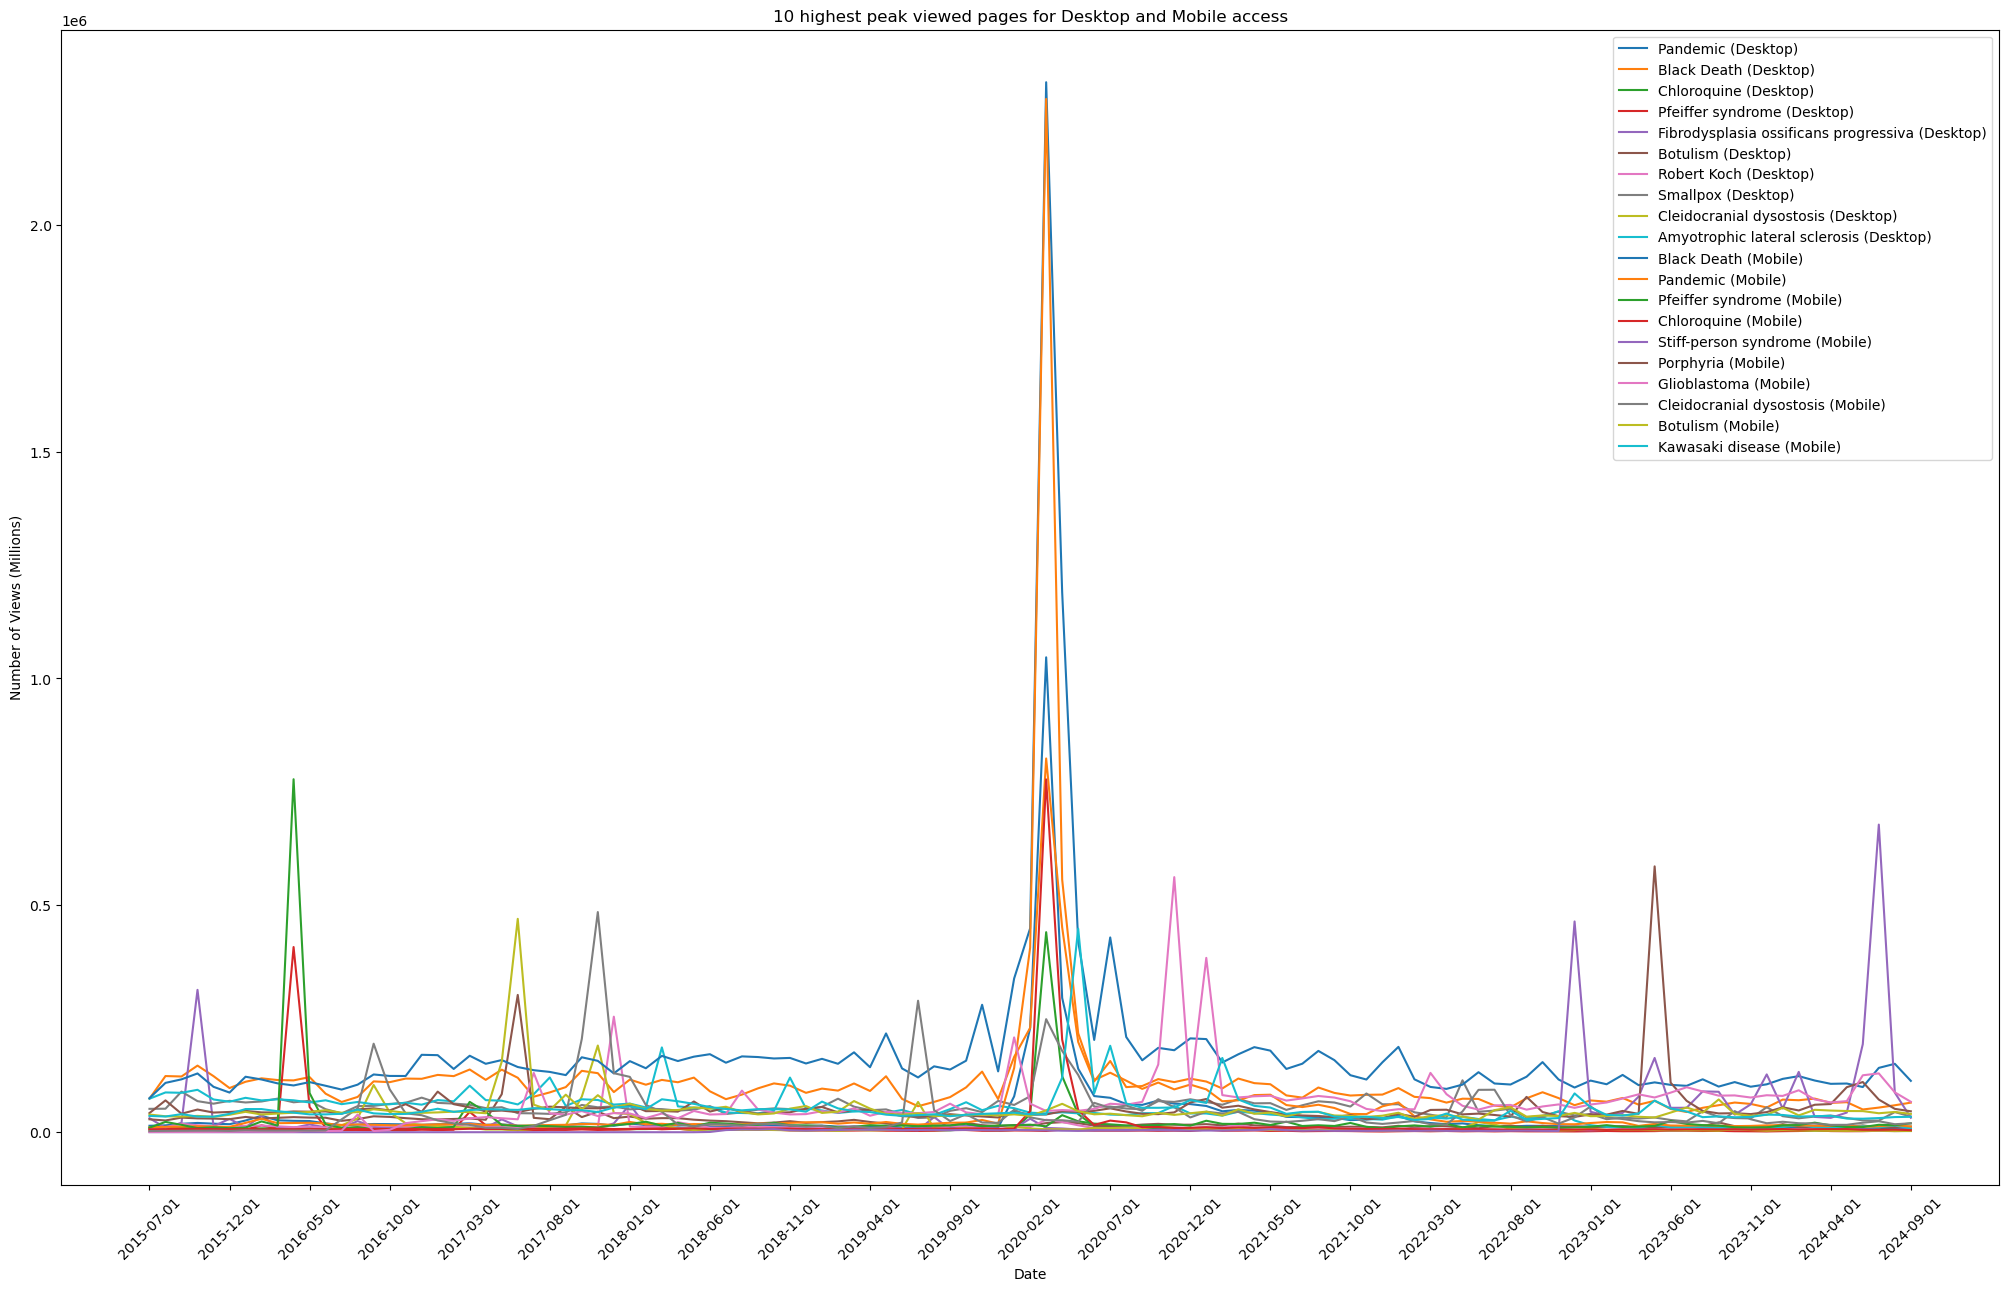

In [32]:
# Find the 10 highest viewed desktop articles
f = open('rare-disease_monthly_desktop_201507-202409.json')
desktop_data = json.load(f)
max_counts = []

# For each article, record the max view count in any given month
for key in desktop_data:
    data_array = desktop_data[key]
    views = getDiseaseArrays(key, 'desktop')
    max_counts.append((key, max(views)))
# Sort in descending order to get the 10 highest viewed pages
sorted_counts = sorted(max_counts, key=lambda x: x[1], reverse=True)
print(sorted_counts[0:10])

# Add the 10 highest viewed pages to the time series chart
plt.figure(figsize=(25, 15))
for i in range(0, 10):
    plt.plot(dates_full, getDiseaseArrays(sorted_counts[i][0], 'desktop'), label=sorted_counts[i][0] + ' (' + 'Desktop' + ')')

    
# Find the 10 highest viewed mobile articles
f = open('rare-disease_monthly_mobile_201507-202409.json')
mobile_data = json.load(f)
max_counts = []
# For each article, record the max view count in any given month
for key in mobile_data:
    data_array = mobile_data[key]
    views = getDiseaseArrays(key, 'mobile')
    max_counts.append((key, max(views)))
# Sort in descending order to get the 10 highest viewed pages
sorted_counts = sorted(max_counts, key=lambda x: x[1], reverse=True)
print(sorted_counts[0:10])

# Add the 10 highest viewed pages to the time series chart
for i in range(0, 10):
    plt.plot(dates_full, getDiseaseArrays(sorted_counts[i][0], 'mobile'), label=sorted_counts[i][0] + ' (' + 'Mobile' + ')')


# Add title and labels to the chart
plt.xticks(dates_full[::5], rotation=45)
plt.title('10 highest peak viewed pages for Desktop and Mobile access')
plt.xlabel('Date')
plt.ylabel('Number of Views (Millions)')
plt.legend()

plt.savefig('visualization2.jpg', format='jpg')



# Visualization 3
Create a time series chart for the 10 desktop articles and the 10 mobile articles that have the least number of monthly records.

[('Retinal vasculopathy with cerebral leukoencephalopathy and systemic manifestations', 33), ('Filippi Syndrome', 34), ('COVID-19 vaccine misinformation and hesitancy', 37), ('CDKL5 deficiency disorder', 40), ('Joseph Vinetz', 40), ('Spongy degeneration of the central nervous system', 41), ('Deaf plus', 41), ('Hemolytic jaundice', 41), ('Bradley Monk', 41), ('Ellis–Van Creveld syndrome', 44)]
[('Retinal vasculopathy with cerebral leukoencephalopathy and systemic manifestations', 33), ('Filippi Syndrome', 34), ('COVID-19 vaccine misinformation and hesitancy', 37), ('CDKL5 deficiency disorder', 40), ('Joseph Vinetz', 40), ('Spongy degeneration of the central nervous system', 41), ('Deaf plus', 41), ('Hemolytic jaundice', 41), ('Bradley Monk', 41), ('Ellis–Van Creveld syndrome', 44)]


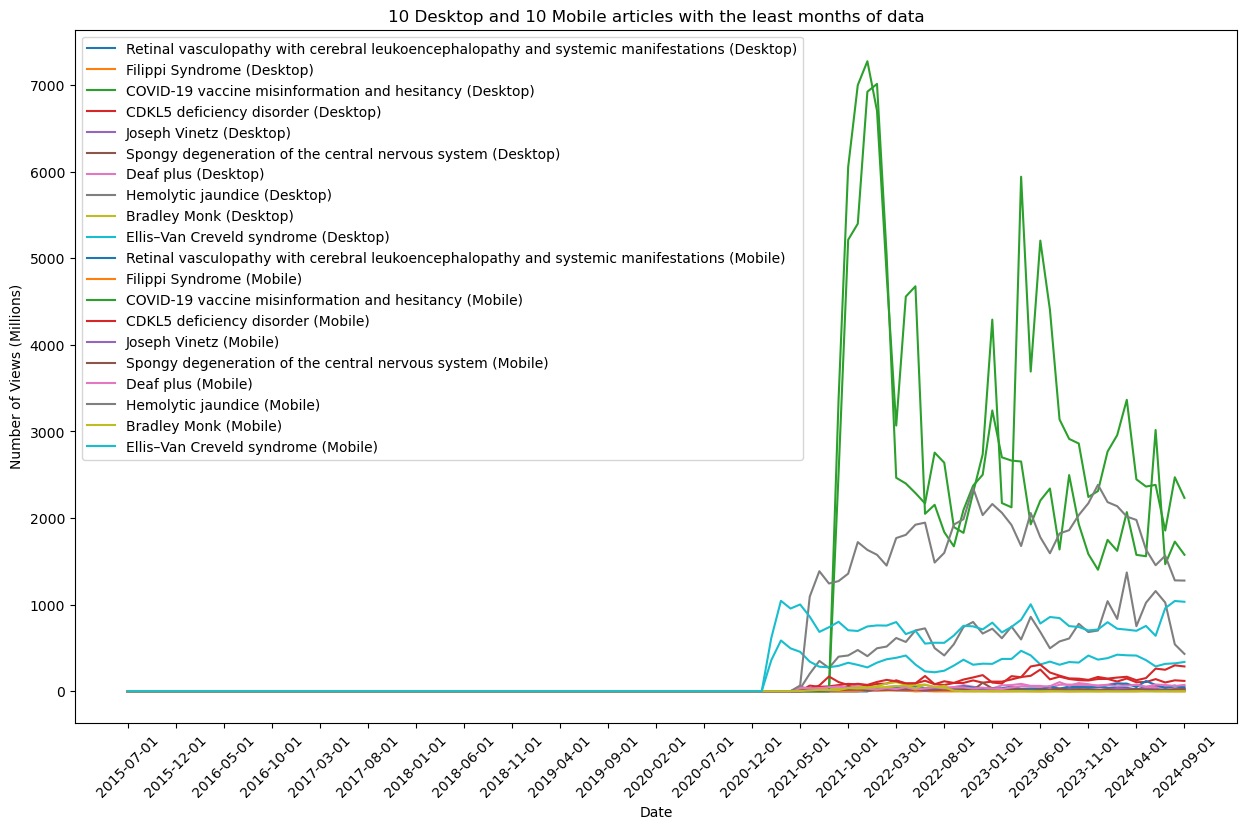

In [33]:
# Find the 10 Desktop articles with the least amount of month data
f = open('rare-disease_monthly_desktop_201507-202409.json')
desktop_data = json.load(f)
month_counts = []
# For each article, record the number of months with data
for key in desktop_data:
    num_months = len(desktop_data[key])
    month_counts.append((key, num_months))
# Sort in increasing order to get the 10 pages with the least months of data
sorted_counts = sorted(month_counts, key=lambda x: x[1], reverse=False)
print(sorted_counts[0:10])

plt.figure(figsize=(15, 9))
for i in range(0, 10):
    plt.plot(dates_full, getDiseaseArrays(sorted_counts[i][0], 'desktop'), label=sorted_counts[i][0] + ' (' + 'Desktop' + ')')


# Find the 10 Mobile articles with the least amount of month data
f = open('rare-disease_monthly_mobile_201507-202409.json')
mobile_data = json.load(f)
month_counts = []
# For each article, record the number of months with data
for key in mobile_data:
    num_months = len(mobile_data[key])
    month_counts.append((key, num_months))
# Sort in increasing order to get the 10 pages with the least months of data
sorted_counts = sorted(month_counts, key=lambda x: x[1], reverse=False)
print(sorted_counts[0:10])

for i in range(0, 10):
    plt.plot(dates_full, getDiseaseArrays(sorted_counts[i][0], 'mobile'), label=sorted_counts[i][0] + ' (' + 'Mobile' + ')')

# Add title and labels to the chart
plt.xticks(dates_full[::5], rotation=45)
plt.title('10 Desktop and 10 Mobile articles with the least months of data')
plt.xlabel('Date')
plt.ylabel('Number of Views (Millions)')
plt.legend()

plt.savefig('visualization3.jpg', format='jpg')

# End of Project